In [1]:
import numpy as np
import mpmath as mp
import renormalization as rg
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
mp.mp.dps = 30
mp.mp.pretty = False

# Transfer matrix for spin-s Ising model

In [6]:
s = .5

T = 1
t = rg.transfer_matrix(s, 1/T)
print(t)

[                             1.0  0.135335283236612691893999494972]
[0.135335283236612691893999494972                               1.0]


# Renormalization group flow

In [3]:
s = 0.5 # Spin number s
T = .1 # Temperature 1/J

p = 0.5 # Antiferromagnetic bond concentration
N = 500 # Bond population
n = 100 # RG iteration number

# Ferro and antiferro transfer matrices
ferro  = rg.transfer_matrix(s,  1/T)
aferro = rg.transfer_matrix(s, -1/T)

t_list = []
for _ in range(int((1 - p) * N)):
    t_list.append(ferro)
for _ in range(int(p * N)):
    t_list.append(aferro)

ij = 19
j = rg.element_ratio(t_list[ij])
X = rg.element_ratio(t_list[ij]) / rg.average_element_ratio_strength(t_list)

print("k    J(ij) / <|J|>      J(ij) \n")
print(0, "   ", X, "             ", j)

flow = [[0, X]]
for k in range(1, n):
    
    t_list = rg.renormalize(N, t_list)
    
    j = rg.element_ratio(t_list[ij])
    j_absavr = rg.average_element_ratio_strength(t_list)
    X = j / j_absavr
    flow.append([k, X])
    print(k, "   ", X, "    ", j)
    
flow = np.array(flow)

k    J(ij) / <|J|>      J(ij) 

0     1.0               10.0
1     -0.799081941673340148574624215773      -9.99999999999999999787582287235
2     1.75116176825709723166421168038      28.7575466751059998494285241164
3     1.62800707843735343715917342456      33.6828279430283144464316057266
4     1.28089220815526843504796243508      35.02387691669531623923198801
5     -1.01913002830003903638708380075      -37.6614978423769689944218003421
6     0.454081172519153742686626935973      22.4695412829975716048006096203
7     -0.632586064583245868623329880709      -42.1303449317562517044120426778
8     -1.44552987608560772798850236208      -127.338495949866103063958675682
9     -1.68519931959747268197424119469      -208.947809995650115100048609314
10     -1.65204139304585402364284213877      -270.506485972056456534228287638
11     -0.560552434716039579861460817161      -116.049372444122825064627706382
12     0.252787832956510682203351400444      65.2953917668534822728914629451
13     -1.407297673

## RG trajectory plot

NameError: name 'linewidths' is not defined

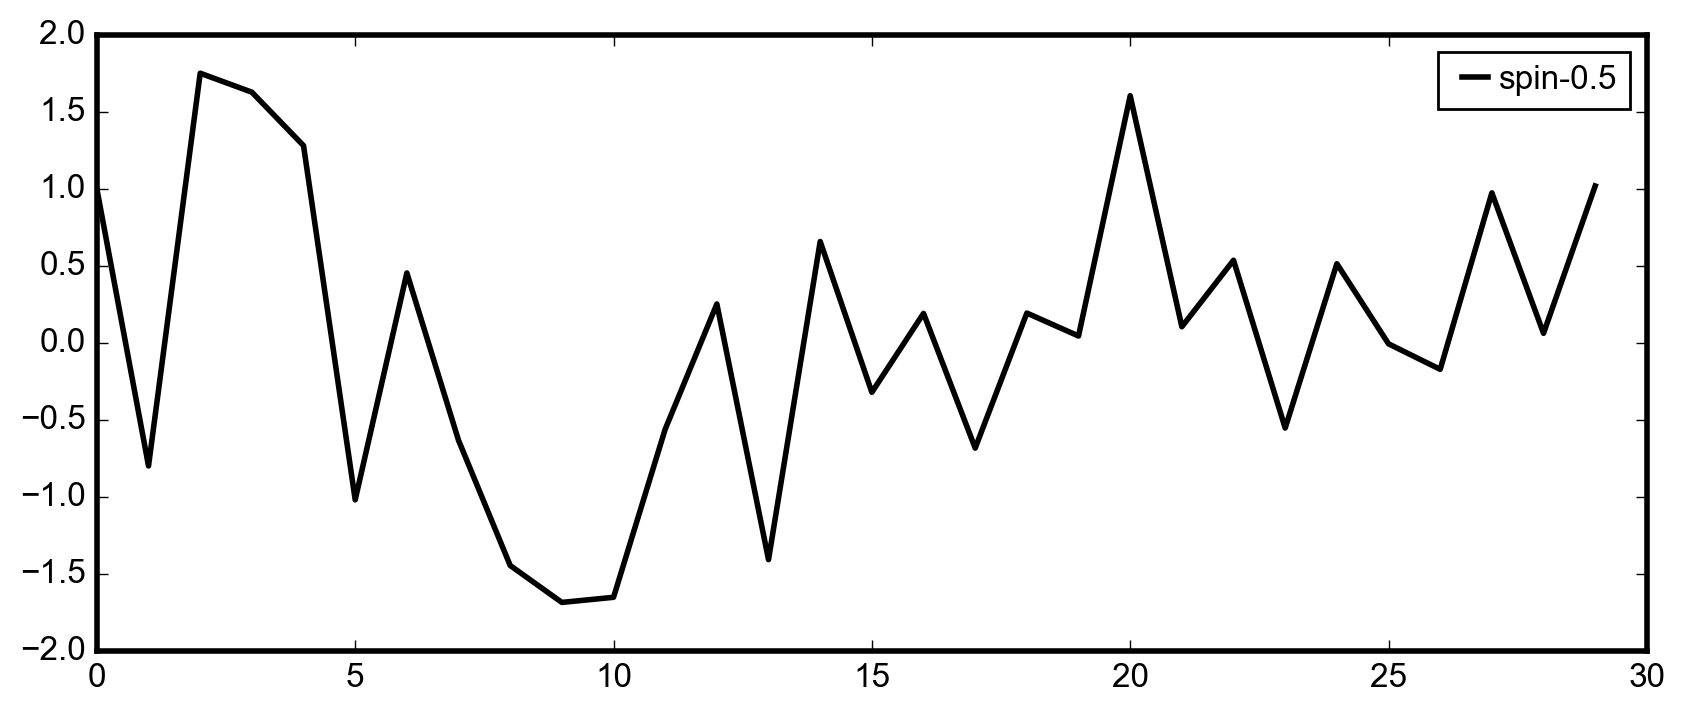

In [4]:
lw = 2
fs = 20
fig = plt.figure(figsize=(10, 4))
fig.set_facecolor('none')
plt.style.use('classic')
plt.rc('lines', linewidth=lw)
plt.rc('axes', linewidth=lw)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'mathtext.default':'regular'})

ax = plt.subplot(111)
ax.plot(flow[:,0], flow[:,1], linestyle='-', marker='', markersize=10, label="spin-" + str(s), color='black')

ax.legend(loc='upper right', ncol=1, prop={'size':fs - 8}, labelspacing=0.5, handlelength=1.4, handletextpad=0)
ax.tick_params(axis="both", direction="in", left=True, width=lw, length=4, labelsize=fs)
ax.set_xlabel(r"Renormalization-group iteration number n", fontsize=fs + 5)
ax.set_ylabel(r"Interaction $\mathrm{J_{ij} / \langle |J| \rangle}$", fontsize=fs + 5)
plt.tight_layout()
plt.show()

In [95]:
mp.mp.dps = 15
mp.mpf(1/3) * 2.5**2

mpf('2.083333333333333')